In [87]:
import os
from utilities import (extract_image_from_pdf, extract_xml_from_digital_pdf,
                       create_directory, read_directory_files, get_subdirectories,
                       get_string_xmltree, get_xmltree, get_specific_tags, get_page_texts_ordered,
                       get_page_text_element_attrib, get_ngram
                      )
from xml_document_info import (get_xml_info)

from box_horizontal_operations import (merge_horizontal_blocks)
from box_vertical_operations import (merge_vertical_blocks)

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import copy


pd.set_option('display.max_rows', None)


## Draw the boxes on document pages

In [82]:
def draw_box(filepath, desired_width, desired_height, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    
    for index, row in df.iterrows():
        left   = int(row['text_left'])
        right  = int(row['text_width'] + left)
        top    = int(row['text_top'])
        bottom = int(row["text_height"] + top)
        
        draw.rectangle(((left, top), (right,bottom)), outline=color)
    save_filepath = os.path.join(os.path.dirname(filepath), 'processed_' + os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

def show_df(df):
    return df.head(df.shape[0])

## start of program

In [5]:
base_dir    = '/home/dhiraj/Documents/Anuwad/document-structure/data'
input_dir  = os.path.join(base_dir, 'input')
output_dir = os.path.join(base_dir, 'output')

#filename   = 'Testa_Dummy_ImuPro_okt2018_5725.pdf'
#filename   = 'v241.pdf'
#filename   = 'downloaded.pdf'
#filename   = '20695_2010_8_1501_20635_Judgement_17-Feb-2020.pdf'
#filename    = '20.03.2020.pdf'
filename    = '6251_2016_3_1501_19387_Judgement_06-Jan-2020.pdf'
#filename   = '4603_2017_11_1503_19663_Judgement_15-Jan-2020.pdf'


os.system('mkdir -p {0}'.format(input_dir))

os.system('mkdir -p {0}'.format(output_dir))



0

In [6]:
pdf_filepath   = os.path.join(input_dir, filename)
working_dir    = os.path.join(output_dir, os.path.splitext(filename)[0])

ret            = create_directory(working_dir)

pdf_image_dir  = extract_image_from_pdf(pdf_filepath, working_dir)
pdf_xml_dir    = extract_xml_from_digital_pdf(pdf_filepath, working_dir)

xml_files      = read_directory_files(pdf_xml_dir, pattern='*.xml')
# print(xml_files, "\n\n")
image_files    = read_directory_files(pdf_image_dir, pattern='*-*.jpg')
# print(image_files)
print("Extracted xml & images of file: %s" % (filename))

Extracted xml & images of file: 6251_2016_3_1501_19387_Judgement_06-Jan-2020.pdf


In [7]:
xml_dfs, page_width, page_height = get_xml_info(xml_files[0])

Total number of pages (151) in file (6251_2016_3_1501_19387_Judgement_06-Jan-2020.xml)


In [8]:
document_configs = {
    'LANGUAGE_TYPE': 'eng',
    
    'HORI_BLOCK_WDTH_DIFF_PERC': 0.85,
    'SUPERSCRIPT_HEIGHT_DIFFERENCE': 7.0,
    'HORI_SPACE_TOO_CLOSE': 10.0,
    
    'VERTICAL_SPACE_TOO_CLOSE': 5.0,
    'AVERAGE_VERTICAL_SPACE': 12.0,
    'LEFT_OR_RIGHT_ALIGNMENT_MARGIN': 20.0
}

In [26]:
file_index     = 0

img_filepath   = image_files[file_index]
df             = xml_dfs[file_index]


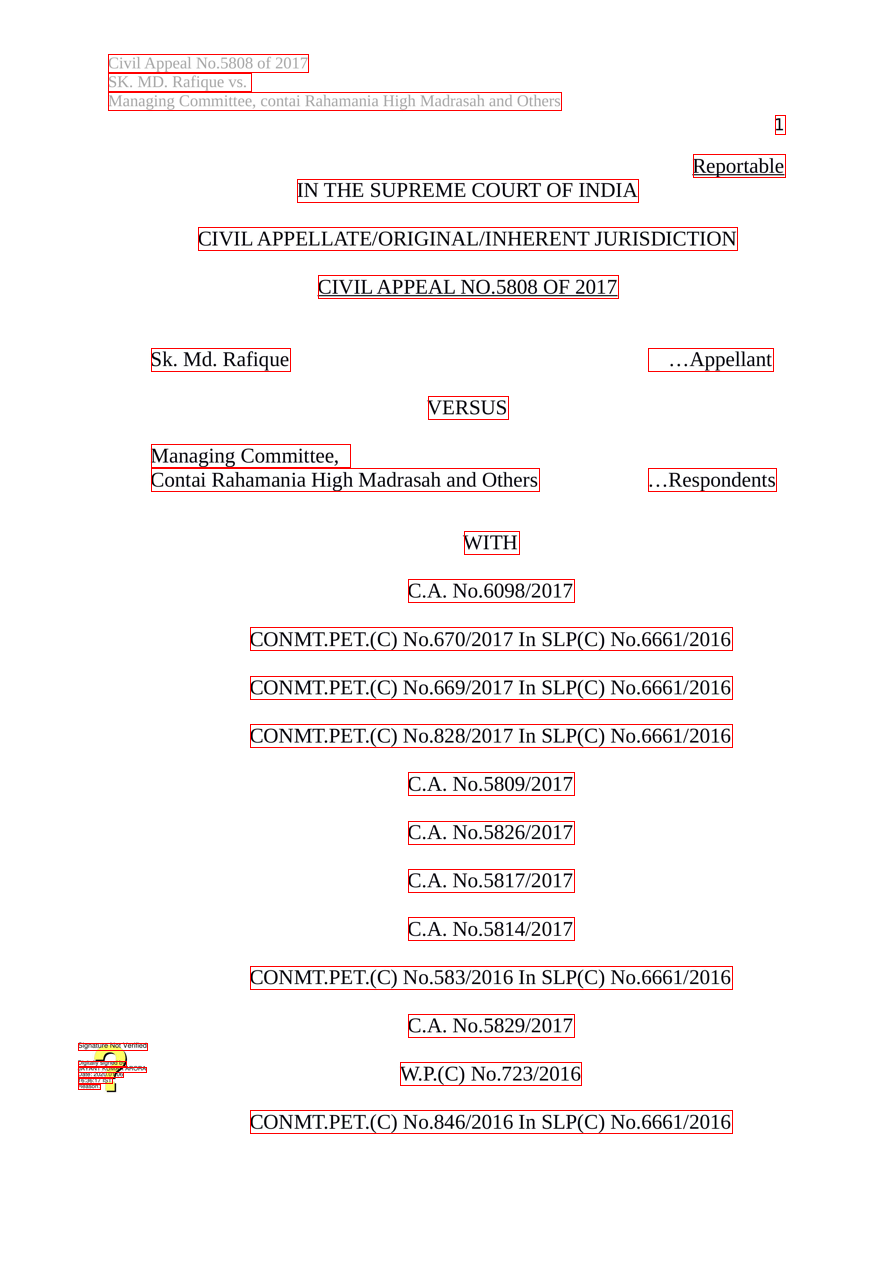

In [27]:
in_df   = df#.loc[:60]

h_df    = merge_horizontal_blocks(in_df, document_configs, debug=False)
v_df    = merge_vertical_blocks(h_df, document_configs, debug=False)

draw_box(img_filepath, page_width, page_height, in_df, color='red')
# show_df(in_df)


In [18]:
#in_df.sort_values(by=['text_left', 'text_top'], axis = 0, ascending = True, inplace=True)
#show_df(in_df)


# Preprocessing for header, footer page num etc

In [96]:
preprocess_config = {'header_cut':0.15  , 'footer_cut' :0.15}

In [62]:
def cut_page(page_df,height,cut_at,direction):
    
    cut_mark = height * cut_at
    if direction == 'above':
        sub_df = page_df[page_df['text_top'] <= cut_mark ]
        
    else :
        sub_df = page_df[page_df['text_top'] >= cut_mark ]
        
    return sub_df


def add_box_coordinates(sub_df):
    sub_df['text_right']  = sub_df['text_left'] + sub_df['text_width']
    sub_df['text_bottom'] = sub_df['text_top'] + sub_df['text_height'] 
    return sub_df

def bb_intersection_over_union(rowA, rowB):
    boxA = [rowA['text_left'] ,rowA['text_top'] , rowA['text_right'] , rowA['text_bottom']]
    boxB = [rowB['text_left'] ,rowB['text_top'] , rowB['text_right'] , rowB['text_bottom']]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA [1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [90]:

def find_header(xml_dfs):
    pdf_levle = []

    page_df   = xml_dfs[0]
    sub_df    = cut_page(page_df,page_height,cut_at=preprocess_config['header_cut'],direction='above')
    sub_df    = add_box_coordinates(sub_df)

    for page2_df in xml_dfs:
        s_df = cut_page(page2_df,page_height,cut_at=preprocess_config['header_cut'],direction='above')
        s_df = add_box_coordinates(s_df)

        page_level = []
        for index1 ,row1 in sub_df.iterrows():   
            iou  = 0
            for index2 , row2 in s_df.iterrows():
                iou += bb_intersection_over_union(row1,row2)

            page_level.append(iou)
        pdf_levle.append(page_level)

    iou_df = pd.DataFrame(pdf_levle,columns=sub_df['text'].values)
    
    return iou_df




def find_footer(xml_dfs):
    pdf_levle = []

    page_df = xml_dfs[0]
    sub_df = cut_page(page_df,page_height,cut_at=preprocess_config['footer_cut'],direction='below')
    sub_df = add_box_coordinates(sub_df)

    for page2_df in xml_dfs:
        s_df     = cut_page(page2_df,page_height,cut_at=preprocess_config['footer_cut'],direction='below')
        s_df = add_box_coordinates(s_df)

        page_level = []
        for index1 ,row1 in sub_df.iterrows():   
            iou  = 0
            for index2 , row2 in s_df.iterrows():
                iou += bb_intersection_over_union(row1,row2)

            page_level.append(iou)
        pdf_levle.append(page_level)

    iou_df = pd.DataFrame(pdf_levle,columns=sub_df['text'].values)
    
    return iou_df

In [91]:
iou_df  = find_header(xml_dfs)

/home/dhiraj/python_env/Anuvaad/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dhiraj/python_env/Anuvaad/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [92]:
show_df(iou_df)

,Civil Appeal No.5808 of 2017,SK. MD. Rafique vs.,"Managing Committee, contai Rahamania High Madrasah and Others",1,Reportable,IN THE SUPREME COURT OF INDIA
0,1.0,1.0,1.0,1.00000,1.000000,1.000000
1,1.0,1.0,1.0,1.00000,0.000000,0.730769
2,1.0,1.0,1.0,1.00000,0.000000,0.601054
3,1.0,1.0,1.0,1.00000,0.144882,0.000000
4,1.0,1.0,1.0,1.00000,0.000000,0.716838
5,1.0,1.0,1.0,1.00000,0.000000,0.707941
6,1.0,1.0,1.0,1.00000,0.000000,0.664938
7,1.0,1.0,1.0,1.00000,0.000000,0.711935
8,1.0,1.0,1.0,1.00000,0.000000,0.707941
9,1.0,1.0,1.0,0.50000,0.146457,0.000000


In [88]:
xml_dfs[8].head()

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color
0,0,54,108,200,18,Civil Appeal No.5808 of 2017,16,BAAAAA+LiberationSerif,#a6a6a6
1,1,73,108,143,18,SK. MD. Rafique vs.,16,BAAAAA+LiberationSerif,#a6a6a6
2,2,92,108,453,18,"Managing Committee, contai Rahamania High Madr...",16,BAAAAA+LiberationSerif,#a6a6a6
3,3,115,775,10,19,9,16,CAAAAA+DejaVuSans,#000009
4,4,154,324,336,22,"the qualification for, and the method...",19,BAAAAA+LiberationSerif,#000000


In [101]:
xml_dfs[9].head()

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color
0,0,54,108,200,18,Civil Appeal No.5808 of 2017,16,BAAAAA+LiberationSerif,#a6a6a6
1,1,73,108,143,18,SK. MD. Rafique vs.,16,BAAAAA+LiberationSerif,#a6a6a6
2,2,92,108,453,18,"Managing Committee, contai Rahamania High Madr...",16,BAAAAA+LiberationSerif,#a6a6a6
3,3,115,764,21,19,10,16,CAAAAA+DejaVuSans,#000009
4,4,154,151,634,23,integration. Section 3 deals with ...,21,BAAAAA+LiberationSerif,#000000


In [99]:
iou_df.sum() / len(iou_df)

Civil Appeal No.5808 of 2017                                     1.000000
SK. MD. Rafique vs.                                              1.000000
Managing Committee, contai Rahamania High Madrasah and Others    1.000000
1                                                                0.475993
Reportable                                                       0.062440
IN THE SUPREME COURT OF INDIA                                    0.446126
dtype: float64

In [95]:
# filter page_number based on region and width 

#  1) check widht based on a configurable range, 
#  2) check text in neighbour hood. 


In [ ]:
# Sub script and super script 

#To do :
    # identify if a sub_block contains a sub/super script, so that it can be removed before tokenization
    

# 1) Check if a line has childern
# 2) Check for subscript based on font heights of all children
# 3) remove sub script 
# 4) sub_block  = {'text'   :  ''  ,  'superscript' : []}

In [ ]:
# Foot note 

    # Check if there is a sub script present in page
    # Fire footnote removal 